<a href="https://www.kaggle.com/code/dheerajrhegde/2-regression-housing-dataset?scriptVersionId=147618260" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/housing-dataset/housing.csv


In [2]:
def load_housing_data():
    csv_path = os.path.join("/kaggle/input/housing-dataset/housing.csv")
    return pd.read_csv(csv_path)
housing = load_housing_data()

### Big Picture
We want to see if we can predict the home prices for new data based on the data available in training data set
This dataset has information about each block from the US Census. 
- median_income: median income in block group
- housing_median_age: median house age in block group
- total_rooms:  number of rooms in the block
- total_bedrooms:  number of bedrooms in the block
- population: block group population
- Household: numnber of household in the block
- median_house_value: median value of the houses in the block
- Latitude: block group latitude
- Longitude: block group longitude
- ocean_proximity

We want to use this data to predict the median property value for a new block
Target - median_house_value
Input - housing_median_age, total_rooms, total_bedrooms, population, Household, Latitude, Longitude, ocean_proximity

### Steps to follow
- Step 1: Explore the data and decide how it needs to be transformed. Make sure you don't change the data column and its correltion. Just transform it in a way to make it more ML ready
    - See correlation
    - find out issues with data and see how it can be fixed
- Step 2: Create train test split
- Step 3: Define objectives of ML
    - Define the metric and target to define a successful ML model
- Step 4: Clean Data. For example, address missing data
- Step 5: Feature engineering - create new features; change categorical features to numeric
- Step 6: Try out different models and see which one seems more fit for purpopse
- Step 7: Pick most promising models and fine tune them

### Key considerations
- Regression needs numeric data
- write reusable functions and pipeline for data processing so that the same can be used for new train data, test data and prediction time

### Step 1: Explore Data

In [3]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [4]:
housing["ocean_proximity"].value_counts()

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

##### Observation - All columns except "ocean_proximity" are numerica/ columns
"ocean_proximity" only has 5 values. So may be a good candidate for one-hot encoding

array([[<Axes: title={'center': 'longitude'}>,
        <Axes: title={'center': 'latitude'}>,
        <Axes: title={'center': 'housing_median_age'}>],
       [<Axes: title={'center': 'total_rooms'}>,
        <Axes: title={'center': 'total_bedrooms'}>,
        <Axes: title={'center': 'population'}>],
       [<Axes: title={'center': 'households'}>,
        <Axes: title={'center': 'median_income'}>,
        <Axes: title={'center': 'median_house_value'}>]], dtype=object)

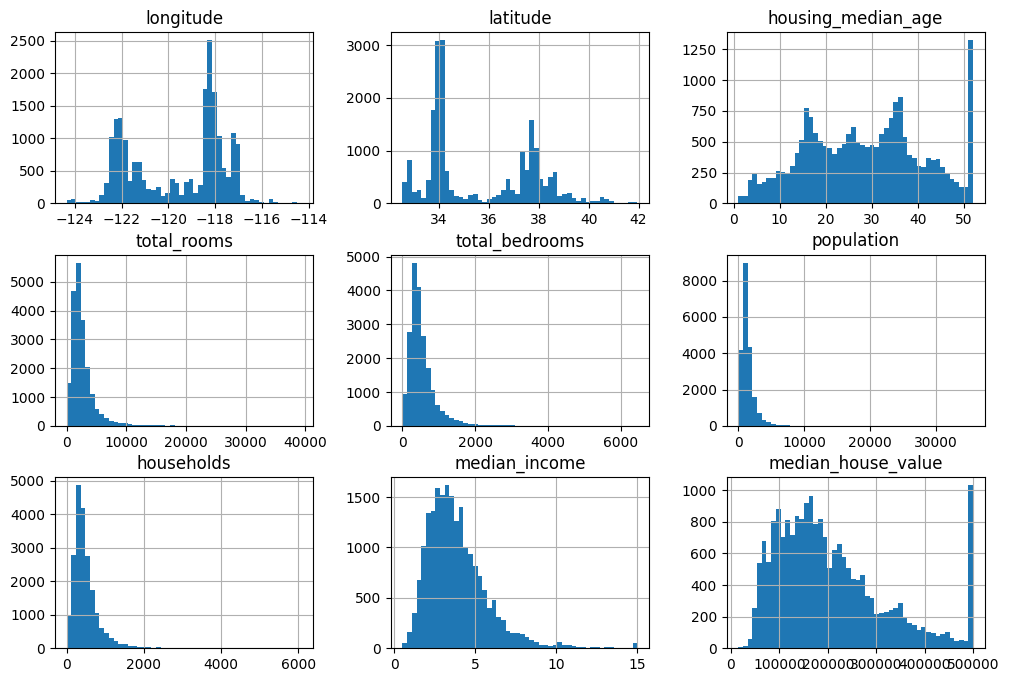

In [5]:
housing.hist(bins=50, figsize=(12,8))

In [6]:
housing['housing_median_age'].value_counts()

housing_median_age
52.0    1273
36.0     862
35.0     824
16.0     771
17.0     698
34.0     689
26.0     619
33.0     615
18.0     570
25.0     566
32.0     565
37.0     537
15.0     512
19.0     502
27.0     488
24.0     478
30.0     476
28.0     471
20.0     465
29.0     461
31.0     458
23.0     448
21.0     446
14.0     412
22.0     399
38.0     394
39.0     369
42.0     368
44.0     356
43.0     353
40.0     304
13.0     302
41.0     296
45.0     294
10.0     264
11.0     254
46.0     245
5.0      244
12.0     238
8.0      206
9.0      205
47.0     198
4.0      191
48.0     177
7.0      175
6.0      160
50.0     136
49.0     134
3.0       62
2.0       58
51.0      48
1.0        4
Name: count, dtype: int64

In [7]:
housing['median_house_value'].value_counts()

median_house_value
500001.0    965
137500.0    122
162500.0    117
112500.0    103
187500.0     93
           ... 
359200.0      1
54900.0       1
377600.0      1
81200.0       1
47000.0       1
Name: count, Length: 3842, dtype: int64

##### Observation - "housing_median_age" seems to be capped at 52. And 'median_house_value' capped at 500001.0

<Axes: xlabel='median_income', ylabel='median_house_value'>

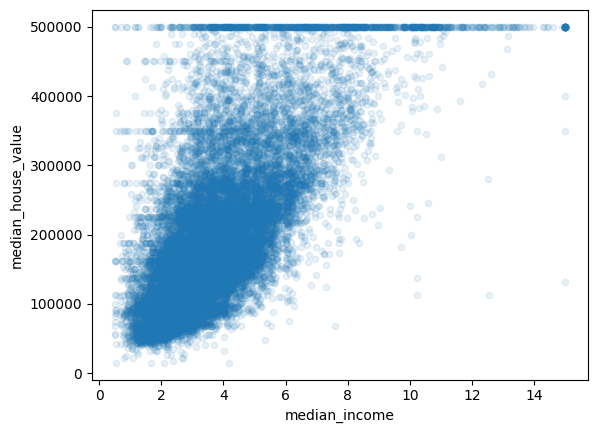

In [8]:
housing.plot(kind="scatter", x="median_income", y="median_house_value", alpha=0.1)

### Step 2: Create train test split
- Option 1: Split randomly
- Option 2: Spit to make sure diffeent groups are equally represented in test and train sets

#### Train/Dev/Test split percentage
- How much data should we keep aside for test? Depends on how big a dataset we have. If we have a huge data set, 10K+ recordds, we can keep aside 10% or less. As less as 1% if we have millions of records
- In case of smaller datasets, we may want to keep aside upto 30% to ensure test dataset error can represent true error well
- Please note that above is with the assumption that we will be using cross valdiation for our "dev error" calc and finding the model we want to use. Test data set will only be used at the end

In [9]:
# hyperparameter
test_ratio = 0.2

In [10]:
indexes = np.random.permutation(len(housing))
test_size = int(test_ratio * len(housing))
test_index = indexes[:test_size]
train_index = indexes[test_size:]
housing_train = housing.iloc[train_index]
housing_test = housing.iloc[test_index]
print(len(housing_train), len(housing_test))

from sklearn.model_selection import train_test_split
housing_train, housing_test = train_test_split(housing, test_size=test_ratio, random_state=42)
print(len(housing_train), len(housing_test))

16512 4128
16512 4128


Issue is that each time we run the split we will get a different train and test sets. Which means, eventually our model creation process would have seen all data from test set during training itself

#### Option 2 - use stratified sampling to ensure each group is represented equally in test and train set

We want to ensure blocks with each income range is represented in test set. Since income is a continue variable in the dataset, we need to convert it into a categorical variable and then use it to do a StratifiedShuffleSplit

In [11]:
housing['median_income'].describe()

count    20640.000000
mean         3.870671
std          1.899822
min          0.499900
25%          2.563400
50%          3.534800
75%          4.743250
max         15.000100
Name: median_income, dtype: float64

In [12]:
from sklearn.model_selection import StratifiedShuffleSplit
housing['income_category'] = pd.cut(housing['median_income'], bins=[0,3,6,9,12,np.inf], labels=[0,1,2,3,4])
split = StratifiedShuffleSplit(n_splits=1, test_size=test_ratio)
for train_index, test_index in split.split(housing, housing['income_category']):
    housing_train = pd.DataFrame(data = housing.iloc[train_index], columns = housing.columns.tolist())
    housing_test = pd.DataFrame(data = housing.iloc[test_index], columns = housing.columns.tolist())

In [13]:
housing_train.shape, housing_test.shape

((16512, 11), (4128, 11))

### Step 3: Define objectives of ML
- We want to predict "median_house_value" using other column. Lets explore the target to understand it better and define learning objectives and accuracy criteria

In [14]:
housing['median_house_value'].describe()

count     20640.000000
mean     206855.816909
std      115395.615874
min       14999.000000
25%      119600.000000
50%      179700.000000
75%      264725.000000
max      500001.000000
Name: median_house_value, dtype: float64

<Axes: >

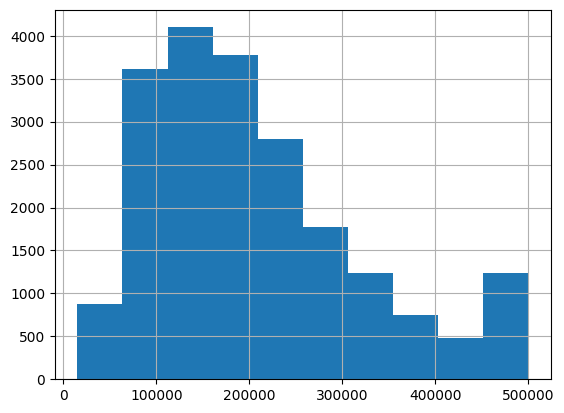

In [15]:
housing['median_house_value'].hist()

Value ranges from 15K to 500K.So we should keep our RMSE for the dataset to be under 1K to ensure we are predicting accurately in low priced market

### Step 4 - Clean Data
- Impute missing data

#### We want to make cleaning, feature engineering, to be rusable acess train, test and prediction. So will use pipelines to include these data processing steps

In [16]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import OneHotEncoder

#dropping "income_category" since it purpose of splitting data is fulfilled
housing_test.drop('income_category', axis=1, inplace=True)
housing_train.drop('income_category', axis=1, inplace=True)
housing.drop('income_category', axis=1, inplace=True)

housing_train_X = housing_train.drop('median_house_value', axis=1)
housing_train_y = np.array(housing_train['median_house_value']).reshape(housing_train.shape[0],1)

housing_test_X = housing_test.drop('median_house_value', axis=1)
housing_test_y = np.array(housing_test['median_house_value']).reshape(housing_test.shape[0],1)

housing_X = housing.drop('median_house_value', axis=1)
housing_y = np.array(housing['median_house_value']).reshape(housing.shape[0],1)

numerical_data_column_index = [0,1,2,3,4,5,6,7]
categorical_data_column_index = [8]

In [17]:
housing_train_X.shape, housing_test_X.shape

((16512, 9), (4128, 9))

### Step 5: Feature engineering
- convert categorical data into one hot encoding
    - CustomEncoder for one hot encoding
- create new columns with derived data if needed
    - AttributeAdder for creating 
- Scale the dataset to make the learning efficient
    - can use min-max scaler or normalize
    - we will normalize here

In [18]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
class AttributeAdder(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        bedrm_per_room = X[:,4] / X[:,3]
        rm_per_household = X[:,3] / X[:,6]
        return np.c_[X, bedrm_per_room, rm_per_household]


In [19]:
numeric_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('attribute_added', AttributeAdder()),
    ('std_scaler', StandardScaler())
])
full_pipeline = ColumnTransformer([
    ("numeric", numeric_pipeline, numerical_data_column_index),
    ('categorical',OneHotEncoder(), categorical_data_column_index)
])
housing_train_X = full_pipeline.fit_transform(housing_train_X)
housing_test_X = full_pipeline.fit_transform(housing_test_X)
housing_X = full_pipeline.fit_transform(housing_X)

In [20]:
housing_train_X.shape, housing_test_X.shape

((16512, 15), (4128, 15))

In [21]:
housing_train_X[0], housing_test_X[0]

(array([ 0.59318935, -0.73640165,  0.50545004, -0.08430886,  0.0319824 ,
        -0.23297641,  0.0581693 , -0.41234888,  0.17417565, -0.30690852,
         1.        ,  0.        ,  0.        ,  0.        ,  0.        ]),
 array([ 1.25846943, -1.3689763 , -0.92418165, -0.85632735, -0.38320484,
        -0.44176913, -0.40388549, -1.28749375,  2.99891666, -1.07324939,
         0.        ,  0.        ,  0.        ,  0.        ,  1.        ]))

In [22]:
housing_train_y[0], housing_test_y[0]

(array([345300.]), array([96400.]))

### Step 6: Try out different models
- Linear Regression, ridge, lasso
- SVR with kernels, LinearSVR
- Random Forest
- Decision Tree Regressor

In [23]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import cross_val_score
lin = LinearRegression()
lin_rmse = cross_val_score(lin, housing_train_X, housing_train_y, scoring="neg_root_mean_squared_error", cv=5)
print("Linear Regression error", np.mean(lin_rmse), np.std(lin_rmse))

Linear Regression error -68691.98200886269 1488.4386096037122


In [24]:
ridge = Ridge(alpha=0.01)
ridge_rmse = cross_val_score(ridge, housing_train_X, housing_train_y, scoring="neg_root_mean_squared_error", cv=5)
print("Ridge Regression error", np.mean(ridge_rmse), np.std(ridge_rmse))
lasso = Lasso(max_iter=10000)
lasso_rmse = cross_val_score(lasso, housing_train_X, housing_train_y, scoring="neg_root_mean_squared_error", cv=5)
print("Lasso Regression error", np.mean(lasso_rmse), np.std(lasso_rmse))

Ridge Regression error -68691.94869465027 1488.379758804662
Lasso Regression error -68691.7490787562 1487.632479039727


In [25]:
from sklearn.svm import LinearSVR
svr = LinearSVR()
svr.fit(housing_train_X, housing_train_y.ravel())
svr_rmse = cross_val_score(svr, housing_train_X, housing_train_y.ravel(), scoring="neg_root_mean_squared_error", cv=5)
print("Linear SVR Regression error", np.mean(svr_rmse), np.std(svr_rmse))

Linear SVR Regression error -222342.06266631506 2435.8893658745933


In [26]:
from sklearn.svm import SVR
svr = SVR()
svr_rmse = cross_val_score(svr, housing_train_X, housing_train_y.ravel(), scoring="neg_root_mean_squared_error", cv=5)
print("SVR rbf with Regression error", np.mean(svr_rmse), np.std(svr_rmse))

SVR rbf with Regression error -118719.43268912137 2134.2554531870724


In [27]:
from sklearn.svm import SVR
svr = SVR(kernel="sigmoid")
svr_rmse = cross_val_score(svr, housing_train_X, housing_train_y.ravel(), scoring="neg_root_mean_squared_error", cv=5)
print("SVR Sigmoind Regression error", np.mean(svr_rmse), np.std(svr_rmse))

SVR Sigmoind Regression error -118458.52032803235 2132.798812373574


In [28]:
from sklearn.svm import SVR
svr = SVR(kernel="poly")
svr_rmse = cross_val_score(svr, housing_train_X, housing_train_y.ravel(), scoring="neg_root_mean_squared_error", cv=5)
print("SVR poly Regression error", np.mean(svr_rmse), np.std(svr_rmse))

SVR poly Regression error -118977.37222130985 1921.0030491137693


In [29]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures().fit_transform(housing_train_X, housing_train_y)
poly_rmse = cross_val_score(lin, poly, housing_train_y.ravel(), scoring="neg_root_mean_squared_error", cv=5)
print("Linear Regression with poly feature error", np.mean(svr_rmse), np.std(svr_rmse))

Linear Regression with poly feature error -118977.37222130985 1921.0030491137693


In [30]:
from sklearn.tree import DecisionTreeRegressor
dt = DecisionTreeRegressor()
dt_rmse = cross_val_score(dt, housing_train_X, housing_train_y.ravel(), scoring="neg_root_mean_squared_error", cv=5)
print("Decision Tree Regression  error", np.mean(dt_rmse), np.std(dt_rmse))

Decision Tree Regression  error -71175.11439657588 1309.4302451056392


In [31]:
from sklearn.ensemble import RandomForestRegressor
rfr = RandomForestRegressor()
rfr_rmse = cross_val_score(rfr, housing_train_X, housing_train_y.ravel(), scoring="neg_root_mean_squared_error", cv=5)
print("Random Forest Regression  error", np.mean(rfr_rmse), np.std(rfr_rmse))

Random Forest Regression  error -50521.87954357716 1318.0921109148371


### Step 7: Pick most promising models and fine tune them
Will pick Ridge Regression and Randowm Forest for further exploration

In [32]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
param_grid = [
    {'n_estimators': [10,100, 1000], 'max_features':[2,4,6]},
    {'bootstrap':[False], 'n_estimators': [5,50, 500], 'max_features':[2,4,6,8]}
]
grid = GridSearchCV(rfr, param_grid=param_grid, cv=5, scoring="neg_root_mean_squared_error", return_train_score=True)

In [33]:
grid.fit(housing_train_X, housing_train_y.ravel())

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid=[{'max_features': [2, 4, 6],
                          'n_estimators': [10, 100, 1000]},
                         {'bootstrap': [False], 'max_features': [2, 4, 6, 8],
                          'n_estimators': [5, 50, 500]}],
             return_train_score=True, scoring='neg_root_mean_squared_error')

In [34]:
grid.best_estimator_, grid.best_score_

(RandomForestRegressor(bootstrap=False, max_features=6, n_estimators=500),
 -49303.33924926392)

In [35]:
ridge = Ridge(max_iter=10000)
param_grid = [
    {'solver':['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga'], 
     'alpha':[0.1, 0.01, 0.001, 0.0001]}
]
grid = GridSearchCV(ridge, param_grid=param_grid, cv=5, return_train_score=True)
grid.fit(housing_train_X, housing_train_y.ravel())

GridSearchCV(cv=5, estimator=Ridge(max_iter=10000),
             param_grid=[{'alpha': [0.1, 0.01, 0.001, 0.0001],
                          'solver': ['auto', 'svd', 'cholesky', 'lsqr',
                                     'sparse_cg', 'sag', 'saga']}],
             return_train_score=True)

In [36]:
grid.best_estimator_, grid.best_score_

(Ridge(alpha=0.1, max_iter=10000, solver='lsqr'), 0.6482851516088891)

In [37]:
best_rfr = RandomForestRegressor(bootstrap=False, max_features=6, n_estimators=500)
best_ridge = Ridge(alpha=0.1, max_iter=10000, solver='saga')

In [38]:
best_rfr.fit(housing_train_X, housing_train_y.ravel())
best_ridge.fit(housing_train_X, housing_train_y.ravel())

Ridge(alpha=0.1, max_iter=10000, solver='saga')

In [39]:
rfr_prediction = best_rfr.predict(housing_test_X)
ridge_prediction = best_ridge.predict(housing_test_X)
dt.fit(housing_train_X, housing_train_y.ravel())
dt_prediction = dt.predict(housing_test_X)

In [40]:
from sklearn.metrics import mean_squared_error
print("Random Forest ",np.sqrt(mean_squared_error(housing_test_y, rfr_prediction)))
print("Ridge ",np.sqrt(mean_squared_error(housing_test_y, ridge_prediction)))
print("Decision Tree ",np.sqrt(mean_squared_error(housing_test_y, dt_prediction)))

Random Forest  54421.58700283763
Ridge  67368.15725590625
Decision Tree  80048.30303389237


### Randowm Forest seems to be the best option with least RMSE
Still not the best accuracy

In [41]:
housing_train_X.tofile('train_X.csv', sep=",")
housing_test_X.tofile('test_X.csv', sep=",")
housing_train_y.tofile('train_y.csv', sep=",")
housing_test_y.tofile('test_y.csv', sep=",")